# Gene essentiality

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [29]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7fcc0222b940>

In [30]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

## Essentiality

M-model

In [31]:
from bacillusme.analysis import essentiality as es
genes = [gene.id for gene in bsub.genes]

In [5]:
essentiality_df_m,flux_responses_m = es.gene_essentiality(bsub,genes, 'm',NP=10,threshold = 0.01,precision=1e-6)

10 threads:   0%|          | 0/844 [00:00<?, ?it/s]

Solving model for base solution


10 threads: 100%|██████████| 844/844 [00:58<00:00,  9.49it/s]

Done


In [6]:
flux_responses_m.to_csv('essentiality/essentiality_raw_results.csv')

ME-model

In [ ]:
genes = [gene.id for gene in me.genes]
essentiality_df_me,flux_responses_me = es.gene_essentiality(me,genes,'me',NP=10,threshold = 0.01,precision=1e-6)

Solving model for base solution


10 threads: 100%|██████████| 844/844 [01:10<00:00,  9.49it/s]

In [ ]:
flux_responses_me.to_csv('essentiality/essentiality_raw_me_results.csv')

### Combine results

In [21]:
essentiality_df = essentiality_df_me.join(essentiality_df_m,lsuffix='_me',rsuffix='_m')

## M/ME comparison

In [ ]:
difference_df = essentiality_df[essentiality_df.essentiality_m != essentiality_df.essentiality_me].dropna()
difference_df

## Reported essentiality

In [43]:
gene_dictionary = pd.read_csv('../building_data/gene_name_dictionary.csv',index_col=0)
essential_genes = pd.read_csv('./essentiality/subtiwiki_essential.txt',index_col=0,sep='\t')

In [44]:
from Bio import SeqIO
gb_file = SeqIO.read("../building_data/NC_000964.gb", 'gb')
gene_count = 0
for feature in gb_file.features:
    if feature.type not in {'CDS', 'rRNA','tRNA', 'ncRNA'}:
        continue
    gene_count += 1
print(gene_count)

4443


In [45]:
all_genes = [g.id for g in me.genes]

In [46]:
true_essentiality = {}
for locus_id in all_genes:
    name = gene_dictionary.loc[locus_id]['name']
    if name in essential_genes.index.values:
        true_essentiality[locus_id] = 'e'
    else:
        true_essentiality[locus_id] = 0
true_essentiality_df = pd.DataFrame({'true_essentiality':true_essentiality})

In [ ]:
essentiality_df = essentiality_df.join(true_essentiality_df)

In [16]:
essentiality_df.to_csv('essentiality/essentiality_results.csv')

### Read

In [62]:
# Read
essentiality_df = pd.read_csv('essentiality/essentiality_results.csv',index_col=0)

In [63]:
essentiality_df[(essentiality_df[field]=='e')]

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU00130,-1.0,e,NaN,NaN,e
BSU00380,-1.0,e,-3.094428e-10,0,e
BSU00280,-1.0,e,-1.000000e+00,e,e
BSU00550,-1.0,e,NaN,NaN,0
BSU00500,-1.0,e,-1.000000e+00,e,0
...,...,...,...,...,...
BSU41060,-1.0,e,NaN,NaN,0
BSU40550,-1.0,e,-1.000000e+00,e,e
BSU40910,-1.0,e,NaN,NaN,0
BSU40420,-1.0,e,-1.000000e+00,e,0


In [64]:
models = ['m','me']
scores = {}
for m in models:
    scores[m] = {}
    
    field = 'essentiality_{}'.format(m)
    P = essentiality_df[(essentiality_df[field]=='e')].shape[0]
    N = essentiality_df[(essentiality_df[field]=='0')].shape[0]
    TP = essentiality_df[essentiality_df[field]=='e'][essentiality_df.true_essentiality=='e'].shape[0]
    FP = P-TP
    TN = essentiality_df[essentiality_df[field]=='0'][essentiality_df.true_essentiality=='0'].shape[0]
    FN = N-TN
    
    FDR = FP/(FP+TP)
    precision = TP/(TP+FP)
    TPR = TP/(TP+FN)
    MCC = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    coverage = (P+N)/gene_count
    
    print(TP,FP,TN,FN)
    
    scores[m]['Precision'] = precision
    scores[m]['FDR'] = FDR
    scores[m]['TPR'] = TPR
    scores[m]['MCC'] = MCC
    scores[m]['Coverage'] = coverage
    
scores_df = pd.DataFrame.from_dict(scores)

57 117 567 23
143 168 592 20


/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:9 UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:11 UserWarning: Boolean Series key will be reindexed to match DataFrame index.


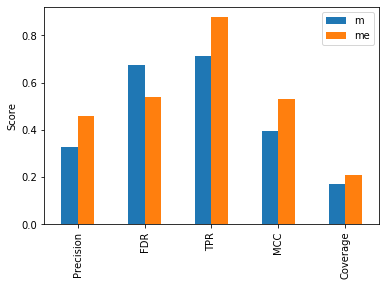

In [65]:
scores_df.plot.bar()
plt.ylabel('Score')
plt.savefig('essentiality/essentiality_scores')

In [67]:
essentiality_df[essentiality_df.essentiality_me=='e']

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU00130,-1.0,e,NaN,NaN,e
BSU00380,-1.0,e,-3.094428e-10,0,e
BSU00280,-1.0,e,-1.000000e+00,e,e
BSU00550,-1.0,e,NaN,NaN,0
BSU00500,-1.0,e,-1.000000e+00,e,0
...,...,...,...,...,...
BSU41060,-1.0,e,NaN,NaN,0
BSU40550,-1.0,e,-1.000000e+00,e,e
BSU40910,-1.0,e,NaN,NaN,0
BSU40420,-1.0,e,-1.000000e+00,e,0
